# Multistrategy Portfolio Research

- This notebook implements aggregate portfolio of multiple personally created strategies that span numerous quantitative financial themes (e.g., momentum, RV, TS, portfolio optimization-based strategies, etc.)

- DPO & MVO portfolio optmization algorithms are applied to aggregate portfolio for comparative analyses

- DPO has statistically significant alpha over MVO and has empirically generated robust risk-adjusted returns on a walk-forward basis across multiple simulations

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtest_tools.portfolio_tools as pt

In [2]:
# ---------------------- Import Strategy Classes ----------------------

# DASR Alphas
from strategy_classes.dasr_optimized_portfolio_strategy.dasr_optimized_portfolio_strategy_class import dasr_optimized_portfolio
from strategy_classes.dasr_optimized_portfolio_strategy import dasr_optimized_portfolio_strategy_class

# Long-Only Momentum Alphas
from strategy_classes.long_only_etf_momentum.sma_confluence_strategy_class import sma_confluence_strategy
from strategy_classes.long_only_etf_momentum.sma_crossover_strategy_class import sma_crossover_strategy
from strategy_classes.long_only_etf_momentum.sma_dual_crossover_strategy_class import sma_dual_crossover_strategy

Create Utility Functions

In [112]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

# -------------------------------------- Portfolio Optimization Functions --------------------------------------
def portfolio_dasr(w: pd.Series, returns: pd.DataFrame, neg = True) ->  float:
    """ Computes DASR of weighted portfolio.

    Args:
        betas (pd.Series): daily expected returns from normalized linear regression.
        squared_residuals (pd.DataFrame): squared error from OLS regression.
        w (pd.Series): portfolio weights.

    Returns:
        float: _description_
    """

    # Get weighted returns
    returns = (returns * w).sum(1)
    # Get weighted portfolio DASR
    portfolio_dasr = pt.drift_adjusted_sharpe_ratio(returns.dropna())

    if neg:
        # Return negative DASR for portfolio optimization
        return (-portfolio_dasr)
    
    # Return real DASR for performance analysis purposes
    return portfolio_dasr

def max_dasr_optimization(returns: pd.DataFrame, long_only=False, constrained=True, max_position_weight=1, vol_target=None) -> pd.Series:
    """ Executes constrained convex portfolio optimization to generate optimal
        DASR asset weights.

    Args:
        returns (pd.DataFrame): Asset returns.

    Returns:
        pd.Series: Optimal DASR portfolio weights.
    """

    n = len(returns.columns)

    # Initial guess is naive 1/n portfolio
    w = np.array([1 / n] * n)

    # Declare constraints list
    constraints =  []

    # Set constraints (e.g., leverage, vol target, max sizing)
    if constrained:

        # Max position size
        if long_only:
            # Long only constraint
            bounds = Bounds(0, max_position_weight)
        else:
            # L/S constraint
            bounds = Bounds(-max_position_weight, max_position_weight)

        # constraints =  [# Weights Constraint
        #         {"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1},
        #         # {"type": "eq", "fun": lambda w: np.sum(w) - 0},
        #         ]
        # No Leverage Constraint
        constraints.append({"type": "eq", "fun": lambda w: np.sum(np.abs(w)) - 1})

        # Volatility Targeting
        if vol_target is not None:           
            constraints.append({"type": "eq", "fun": lambda w: np.sqrt(np.dot(np.dot(w.T, returns.cov()), w)) - vol_target})
    else:
        # Is not implementable nor optimal
        bounds = Bounds(-100, 100)

        constraints =  []
    
    # Get optimized weights
    w = pd.Series(minimize(portfolio_dasr, 
                            w,
                            args=(returns), 
                            method='SLSQP',
                            bounds = bounds,
                            constraints=constraints)['x'],
                index=returns.columns
                )
    
    return w

def multistrategy_portfolio_optimization(multistrategy_portfolio: pd.DataFrame, rebal_freq: int, lookback_window: int, optimization = ['MVO', 'DPO', 'Closed Form MVO'], vol_target=None, max_position_weight=.2, constrained=True):
    """ Executes multistrategy portfolio optimization by leveraging either one of two different optimization algorithms: 
        - MVO
        - Drift Adjusted Portfolio Optimization

    Args:
        multistrategy_portfolio (pd.DataFrame): _description_
        rebal_freq (int): _description_
        lookback_window (int): _description_
        optimiztion (list, optional): _description_. Defaults to ['MVO', 'DPO'].
        vol_target (float, optional): _description_. Defaults to .01.
        max_position_weight (float, optional): _description_. Defaults to .5.
    """

    w = {}

    if optimization == 'MVO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
        
            w[date] = pt.mvo(hist_returns=multistrategy_portfolio.loc[:date], expected_returns=multistrategy_portfolio.loc[:date].tail(lookback_window).mean(), vol_target=vol_target, max_position_weight=max_position_weight, constrained=constrained, verbose=False, long_only=True)
    
    elif optimization == 'DPO':
        for date in multistrategy_portfolio.index[::rebal_freq]:
            w[date] = max_dasr_optimization(returns=multistrategy_portfolio.loc[:date].tail(lookback_window), long_only=True, constrained=constrained, max_position_weight=max_position_weight, vol_target=vol_target)

    # Convert Hash Table to DataFrame
    indices_df = pd.DataFrame(index=multistrategy_portfolio.index)
    w = pd.concat([indices_df, pd.DataFrame(w).T], axis=1).ffill().dropna()

    # Get strategy returns
    multistrategy_portfolio_optimized_returns = (multistrategy_portfolio*w.shift(2)).sum(1).dropna()

    return multistrategy_portfolio_optimized_returns, w

# Create Multistrategy Portfolio

In [38]:
multistrategy_portfolio = {}

# ------------------------------ Get DASR Strategies ------------------------------ 
for i in range(0, 8):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\dasr_optimized_portfolio_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[f'{i} DASR'] = strategy.strategy_returns

# ------------------------------ Get SMA Confluence Strategies ------------------------------ 
for i in range(0, 1): 

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\sma_confluence_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[f'{i} SMA Confluence'] = strategy.strategy_returns

# ------------------------------  Get SMA Crossover Strategies ------------------------------ 
for i in range(0, 1):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\sma_crossover_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[f'{i} SMA Crossover'] = strategy.strategy_returns


# ------------------------------  Get SMA Crossover Strategies ------------------------------ 
for i in range(0, 2):

    path = fr'C:\Users\marcu\Documents\Quant\Programming\Strategies\Beta Strategies\sma_dual_crossover_strategy_{i}.pickle'
    
    with open(path, 'rb') as handler:
        strategy = pickle.load(handler)
        multistrategy_portfolio[f'{i} SMA Dual Crossover'] = strategy.strategy_returns
     
multistrategy_portfolio = pd.DataFrame(multistrategy_portfolio)

Text(0.5, 1.0, 'Individual Strategies')

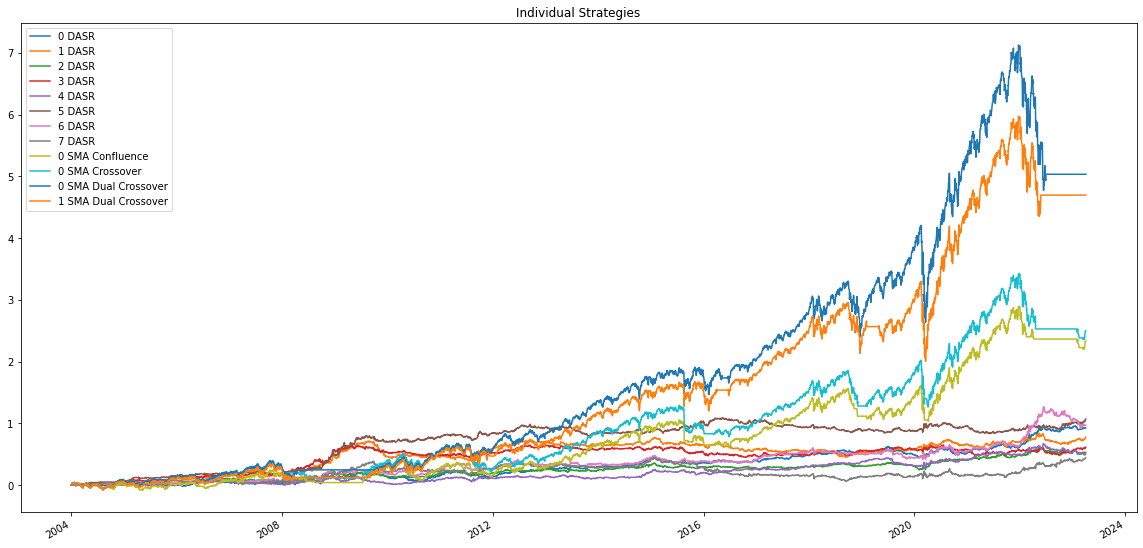

In [150]:
pt.cumulative_returns(multistrategy_portfolio.loc[dt.date(2004, 1, 1):]).plot(figsize=(20, 10))
plt.title('Individual Strategies')

In [24]:
import datetime as dt

# Isolate portfolio returns post-2004
multistrategy_portfolio = multistrategy_portfolio.loc[dt.date(2004, 1, 1):]

Optimize Multistrategy Portfolio

In [120]:
# Create optimizations for 20 day rebal
rebal_freq = 10
lookback_window = 10
# --------------------- DPO ---------------------
multistrategy_portfolio_dpo_1, dpo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO', max_position_weight=1)
print('DPO 1 DONE')
multistrategy_portfolio_dpo_2, dpo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO', max_position_weight=10)
print('DPO 2 DONE')
multistrategy_portfolio_dpo_3, dpo_w_3 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO', vol_target=.1)
print('DPO 3 DONE')
multistrategy_portfolio_dpo_4, dpo_w_4 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO', vol_target=.01)
print('DPO 4 DONE')
multistrategy_portfolio_dpo_5, dpo_w_5 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'DPO', vol_target=.2)

# --------------------- MVO ---------------------
multistrategy_portfolio_mvo_1, mvo_w_1 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', vol_target=.01, max_position_weight=.2)
print('MVO 1 DONE')
multistrategy_portfolio_mvo_2, mvo_w_2 = multistrategy_portfolio_optimization(multistrategy_portfolio=multistrategy_portfolio, rebal_freq=rebal_freq, lookback_window=lookback_window, optimiztion = 'MVO', constrained=False)
print('MVO 1 DONE')

DPO 1 DONE


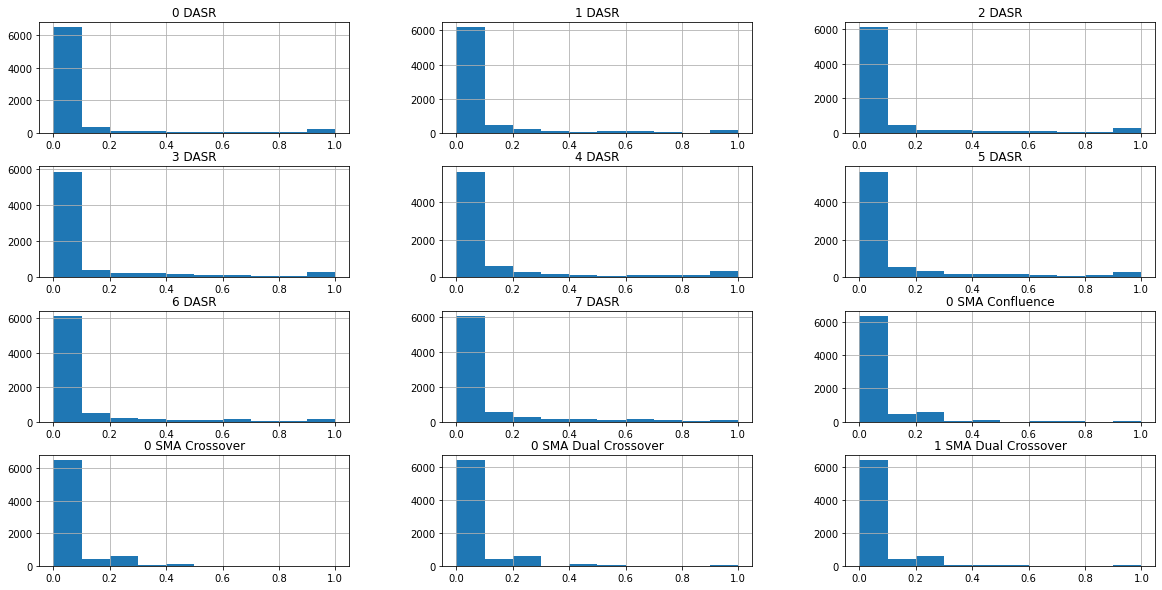

In [155]:
dpo_weights_hist = dpo_w_1.hist(figsize=(20, 10))

Compute Performance Metrics and Benchmark

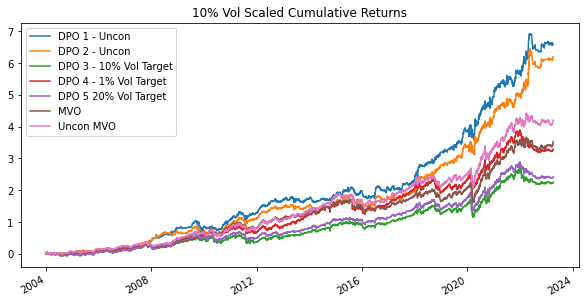

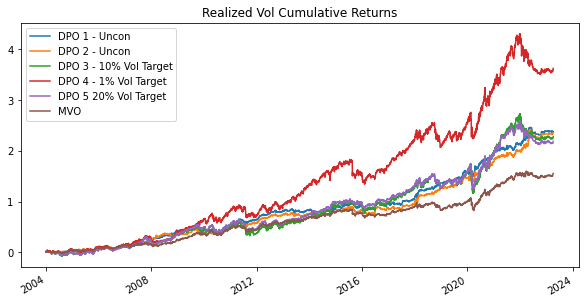

,DPO 1 - Uncon,DPO 2 - Uncon,DPO 3 - 10% Vol Target,DPO 4 - 1% Vol Target,DPO 5 20% Vol Target,MVO,Uncon MVO
Vol Scaled Performance,,,,,,,
Sharpe Ratio,1.104,1.077,0.664,0.808,0.691,0.836,0.908
Drift Adjusted Sharpe Ratio,4.299,3.952,6.667,9.035,8.067,7.859,7.151
CAGR,0.111,0.108,0.063,0.078,0.066,0.081,0.089
Vol,0.100,0.100,0.100,0.100,0.100,0.100,0.100
Sortino Ratio,1.385,1.364,0.800,1.019,0.834,1.055,1.157
Martin (Ulcer) Ratio,2.793,2.587,1.141,1.473,1.248,1.725,1.998
Omega Ratio,1.091,1.085,0.998,1.023,1.003,1.028,1.042
RR Ratio,1.253,1.248,1.130,1.152,1.135,1.158,1.173
Win Rate,0.539,0.539,0.549,0.557,0.550,0.551,0.557


In [156]:
# Store all optimizations' returns
optimization_returns = pd.concat([multistrategy_portfolio_dpo_1, 
                                    multistrategy_portfolio_dpo_2, 
                                    multistrategy_portfolio_dpo_3, 
                                    multistrategy_portfolio_dpo_4, 
                                    multistrategy_portfolio_dpo_5, 
                                    multistrategy_portfolio_mvo_1, 
                                    multistrategy_portfolio_mvo_2], axis=1)
optimization_returns.columns = ['DPO 1 - Uncon', 'DPO 2 - Uncon', 'DPO 3 - 10% Vol Target', 'DPO 4 - 1% Vol Target', 'DPO 5 20% Vol Target','MVO', 'Uncon MVO']

# Get vol scaled performance summary for direct comparison purposes 
optimization_performance_summary_vol_scaled =pd.concat([pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo_1.loc[dt.date(2004, 1, 1):])),
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo_2.loc[dt.date(2004, 1, 1):])),
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo_3.loc[dt.date(2004, 1, 1):])), 
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo_4.loc[dt.date(2004, 1, 1):])),
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_dpo_5.loc[dt.date(2004, 1, 1):])),
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_mvo_1.loc[dt.date(2004, 1, 1):])), 
                                                        pt.performance_summary(pt.scale_vol(multistrategy_portfolio_mvo_2.loc[dt.date(2004, 1, 1):]))], axis=1)

optimization_performance_summary_vol_scaled.columns = optimization_returns.columns
optimization_performance_summary_vol_scaled.index.name = 'Vol Scaled Performance'

# Get realized performance summary for direct comparison purposes 
optimization_performance_summary = pd.concat([pt.performance_summary(multistrategy_portfolio_dpo_1.loc[dt.date(2004, 1, 1):]),
                                              pt.performance_summary((multistrategy_portfolio_dpo_2.loc[dt.date(2004, 1, 1):])),
                                              pt.performance_summary((multistrategy_portfolio_dpo_3.loc[dt.date(2004, 1, 1):])), 
                                              pt.performance_summary((multistrategy_portfolio_dpo_4.loc[dt.date(2004, 1, 1):])),
                                              pt.performance_summary((multistrategy_portfolio_dpo_5.loc[dt.date(2004, 1, 1):])),
                                              pt.performance_summary(multistrategy_portfolio_mvo_1.loc[dt.date(2004, 1, 1):]), 
                                              pt.performance_summary(multistrategy_portfolio_mvo_2.loc[dt.date(2004, 1, 1):])], axis=1)

optimization_performance_summary.columns = optimization_returns.columns
optimization_performance_summary.index.name = 'Realized Performance'

# Plot vol scaled performance
plt.figure(figsize=(10, 5))
for col, temp_rets in optimization_returns.items():
    pt.cumulative_returns(pt.scale_vol(temp_rets.loc[dt.date(2004, 1, 1):])).plot(label=col)

plt.title('10% Vol Scaled Cumulative Returns')
plt.legend()
plt.show()

# Plot realized performance
plt.figure(figsize=(10, 5))
for col, temp_rets in optimization_returns.items():
    if col == 'Uncon MVO':
        continue
    pt.cumulative_returns(temp_rets.loc[dt.date(2004, 1, 1):]).plot(label=col)

plt.title('Realized Vol Cumulative Returns')
plt.legend()
plt.show()

optimization_performance_summary_vol_scaled

In [185]:
optimization_performance_summary

,DPO 1 - Uncon,DPO 2 - Uncon,DPO 3 - 10% Vol Target,DPO 4 - 1% Vol Target,DPO 5 20% Vol Target,MVO,Uncon MVO
Realized Performance,,,,,,,
Sharpe Ratio,1.104,1.077,0.664,0.808,0.691,0.836,0.908
Drift Adjusted Sharpe Ratio,7.881,6.690,6.624,8.450,8.643,12.991,4.980
CAGR,0.065,0.065,0.063,0.082,0.062,0.050,0.116
Vol,0.059,0.060,0.101,0.105,0.094,0.060,0.131
Sortino Ratio,1.385,1.364,0.800,1.019,0.834,1.055,1.157
Martin (Ulcer) Ratio,2.795,2.587,1.141,1.473,1.248,1.727,1.996
Omega Ratio,0.991,0.990,0.999,1.030,0.994,0.951,1.072
RR Ratio,1.253,1.248,1.130,1.152,1.135,1.158,1.173
Win Rate,0.539,0.539,0.549,0.557,0.550,0.551,0.557


In [206]:
import backtest_tools.risk_analysis as ra

Plot Drawdowns

<AxesSubplot:>

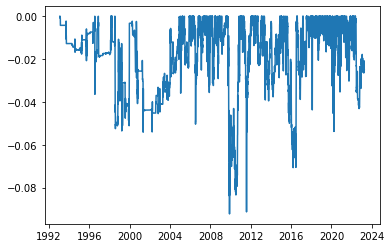

In [213]:
ra.get_drawdowns(multistrategy_portfolio_dpo_1).plot()

<AxesSubplot:>

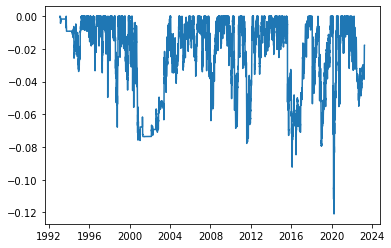

In [211]:
ra.get_drawdowns(multistrategy_portfolio_mvo_1).plot()

Plot Rolling 20 Day Volatility

- DPO is not targeting volatility here, thus, the volatility will be more sparatic

<AxesSubplot:>

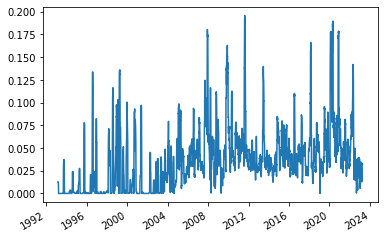

In [212]:
(multistrategy_portfolio_dpo_1.rolling(20).std()*252**.5).plot()

<AxesSubplot:>

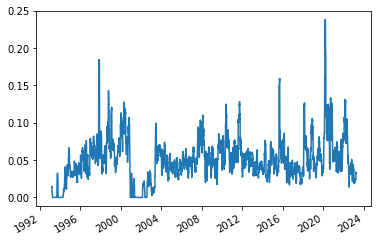

In [204]:
(multistrategy_portfolio_mvo_1.rolling(20).std()*252**.5).plot()